In [1]:
import os, sys, time
import itertools
import imageio
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from dataset import get_data
from scipy.misc import imsave
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils as utils
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as v_utils
from torch.autograd import Variable

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
class arguments():
    def __init__(self):
        self.dataset = 'CelebA'
        self.dataroot = '/data/jehyuk/imgdata'
        self.workers = 2
        self.n_gpu = 1
        self.batchsize = 64
        self.maxepoch = 100
        self.imagesize = 64
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.channel_bunch = 64
        self.use_cuda = True
        self.n_z = 64
        self.result_dir = '/home/jehyuk/GenerativeModels/GAN/results/DCGAN/' + self.dataset
        self.save_dir = '/home/jehyuk/GenerativeModels/GAN/models/DCGAN/' + self.dataset
        self.n_sample = 16

opt = arguments()

In [5]:
torch.manual_seed(20)
torch.cuda.manual_seed_all(20)

In [6]:
def load_dataset(dataroot = opt.dataroot, dataset=opt.dataset):
    data_folder = os.path.join(dataroot, dataset)
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    transform = transforms.Compose([transforms.Scale(opt.imagesize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    if dataset == 'MNIST':
        trn_data = dset.MNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.MNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'Fashion-MNIST':
        trn_data = dset.FashionMNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.FashionMNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'CIFAR10':
        trn_data = dset.cifar.CIFAR10(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.cifar.CIFAR10(data_folder, train=False, transform=transform, download=True)
        n_channels = 3
    elif dataset == 'CelebA':
        trn_data = get_data(data_folder, split='train', image_size=opt.imagesize)
        tst_data = get_data(data_folder, split='test', image_size=opt.imagesize)
        n_channels = 3
    trn_loader = utils.data.DataLoader(trn_data, batch_size=opt.batchsize, shuffle=True, num_workers=opt.workers, drop_last=True)
    tst_loader = utils.data.DataLoader(tst_data, batch_size=opt.batchsize, shuffle=False, num_workers=opt.workers, drop_last=True)
    return trn_loader, tst_loader, n_channels

In [7]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Discriminator, self).__init__()
        self.opt = opt
        self.n_channels = n_channels
        
        layers = nn.Sequential()
        
        layers.add_module("Conv1", nn.Conv2d(self.n_channels, self.opt.channel_bunch, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Activation1", nn.LeakyReLU(negative_slope=0.2))
        
        layers.add_module("Conv2", nn.Conv2d(self.opt.channel_bunch, self.opt.channel_bunch*2, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm2", nn.BatchNorm2d(self.opt.channel_bunch*2))
        layers.add_module("Activation2", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv3", nn.Conv2d(self.opt.channel_bunch*2, self.opt.channel_bunch*4, kernel_size=4, stride=2, padding=1, bias=False)) 
        layers.add_module("Batchnorm3", nn.BatchNorm2d(self.opt.channel_bunch*4))
        layers.add_module("Activation3", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv4", nn.Conv2d(self.opt.channel_bunch*4, self.opt.channel_bunch*8, kernel_size=4, stride=2, padding=1, bias=False)) 
        layers.add_module("Batchnorm4", nn.BatchNorm2d(self.opt.channel_bunch*8))
        layers.add_module("Activation4", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv5", nn.Conv2d(self.opt.channel_bunch*8, 1, kernel_size=4, stride=1, padding=0, bias=False))
        layers.add_module("Activation5", nn.Sigmoid())

        self.layers = layers
    
    def forward(self, x):
        if isinstance(x.data, torch.cuda.FloatTensor) and self.opt.n_gpu > 1:
            x = nn.parallel.data_parallel(module=self.layers, inputs=x, device_ids=self.opt.n_gpu)
        else:
            x = self.layers(x)
        x = x.view(-1,1).squeeze(1)
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Generator, self).__init__()
        self.opt = opt
        self.n_channels = n_channels

        layers = nn.Sequential()

        layers.add_module("TransConv1", nn.ConvTranspose2d(self.opt.n_z, self.opt.channel_bunch*8, kernel_size=4, stride=1, padding=0, bias=False))
        layers.add_module("Batchnorm1", nn.BatchNorm2d(self.opt.channel_bunch*8))
        layers.add_module("Activation1", nn.ReLU(inplace=True))

        layers.add_module("TransConv2", nn.ConvTranspose2d(self.opt.channel_bunch*8, self.opt.channel_bunch*4, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm2", nn.BatchNorm2d(self.opt.channel_bunch*4))
        layers.add_module("Activation2", nn.ReLU(inplace=True))

        layers.add_module("TransConv3", nn.ConvTranspose2d(self.opt.channel_bunch*4, self.opt.channel_bunch*2, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm3", nn.BatchNorm2d(self.opt.channel_bunch*2))
        layers.add_module("Activation3", nn.ReLU(inplace=True))

        layers.add_module("TransConv4", nn.ConvTranspose2d(self.opt.channel_bunch*2, self.opt.channel_bunch, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm4", nn.BatchNorm2d(self.opt.channel_bunch))
        layers.add_module("Actvation4", nn.ReLU(inplace=True))
    
        layers.add_module("TransConv5", nn.ConvTranspose2d(self.opt.channel_bunch, self.n_channels, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Actvation5", nn.Tanh())
    
        self.layers = layers
        
    def forward(self, z):
        if isinstance(z.data, torch.cuda.FloatTensor) and self.opt.n_gpu > 1:
            x = nn.parallel.data_parallel(module=self.layers, inputs=z, device_ids=range(self.opt.n_gpu))
        else:
            x = self.layers(z)
        return x

In [ ]:
class DCGAN(object):
    def __init__(self, opt):
        self.opt = opt
        self.trn_loader, self.tst_loader, self.n_channels = load_dataset(self.opt.dataroot, self.opt.dataset)
        self.is_cuda = torch.cuda.is_available()

        self.G = Generator(self.opt, self.n_channels)
        self.D = Discriminator(self.opt, self.n_channels)
        self.G.apply(initialize_weights)
        self.D.apply(initialize_weights)
        self.sample_z = Variable(torch.randn((self.opt.n_sample, self.opt.n_z, 1, 1)), volatile=True)
        
        if self.is_cuda and self.opt.use_cuda:
            self.G, self.D = self.G.cuda(), self.D.cuda()
            self.sample_z = self.sample_z.cuda()
        
        self.optim_G = torch.optim.Adam(params=self.G.parameters(), lr=self.opt.lrG, betas=(0.5, 0.999))
        self.optim_D = torch.optim.Adam(params=self.D.parameters(), lr=self.opt.lrD, betas=(0.5, 0.999))
        self.BCEloss = nn.BCELoss()
    
    def train(self):
        self.loss_dict=dict()
        self.loss_dict['G_loss'], self.loss_dict['D_fake_loss'], self.loss_dict['D_real_loss'] = list(), list(), list()

        self.D.train()
        print('------------------Start training------------------')
        for epoch in range(self.opt.maxepoch):
            self.G.train()
            print(">>>>Epoch: {}".format(epoch+1))
            start_time = time.time()
            for iter_num, (image, label) in enumerate(self.trn_loader):
                x = Variable(image)
                z1 = Variable(torch.randn((self.opt.batchsize, self.opt.n_z, 1, 1)))
                z2 = Variable(torch.randn((self.opt.batchsize, self.opt.n_z, 1, 1)))
                true_label = Variable(torch.ones(self.opt.batchsize, 1))
                fake_label = Variable(torch.zeros(self.opt.batchsize, 1))
                if self.is_cuda:
                    x, z1, z2 = x.cuda(), z1.cuda(), z2.cuda()
                    true_label, fake_label = true_label.cuda(), fake_label.cuda()
                
                # Train D
                self.D.zero_grad()
                D_x = self.D.forward(x)
                D_x = D_x.squeeze()
                
                G_z = self.G.forward(z1)
                D_G_z = self.D.forward(G_z)
                D_G_z = D_G_z.squeeze()
                
                D_real_loss = self.BCEloss(D_x, true_label)
                D_fake_loss = self.BCEloss(D_G_z, fake_label)
                D_loss = D_real_loss + D_fake_loss
                D_loss.backward()
                self.optim_D.step()

                #Train G             
                self.G.zero_grad()
                G_z = self.G.forward(z2)
                D_G_z = self.D.forward(G_z)
                D_G_z = D_G_z.squeeze()
                G_loss = self.BCEloss(D_G_z, true_label)
                G_loss.backward()
                self.optim_G.step()

                if (iter_num+1) % 100 == 0:
                    print("Epoch: {}, iter: {}, D_real_loss: {:.3f}, D_fake_loss: {:.3f}, G_loss: {:.3f}".format(epoch+1, iter_num+1, D_real_loss.data[0], D_fake_loss.data[0], G_loss.data[0]))
                    self.loss_dict['G_loss'].append(G_loss.data[0])
                    self.loss_dict['D_fake_loss'].append(D_fake_loss.data[0])
                    self.loss_dict['D_real_loss'].append(D_real_loss.data[0])
            print(">>>>Time for 1 epoch: {:.2f}".format(time.time()-start_time))
            self.save_results(epoch+1, self.sample_z)
        self.save_model()
    
    def save_results(self, epoch, sample):
        self.G.eval()
        if not os.path.exists(self.opt.result_dir):
            os.makedirs(self.opt.result_dir)
        fake_file_name = self.opt.result_dir + '/DCGAN_epoch%03d' %epoch + '.png'
        fake_results = self.G.forward(sample)
        v_utils.save_image(fake_results.data, fake_file_name, nrow = int(math.sqrt(self.opt.n_sample)), normalize=True)
    
    def save_model(self):
        if not os.path.exists(self.opt.save_dir):
            os.makedirs(self.opt.save_dir)
        torch.save(self.G.state_dict(), os.path.join(self.opt.save_dir, 'G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(self.opt.save_dir, 'D.pkl'))
        with open(os.path.join(self.opt.save_dir, 'loss_dict'), 'wb') as f:
            pickle.dump(self.loss_dict, f)
    
    def load_model(self):
        self.G.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'D.pkl')))

In [ ]:
dcgan = DCGAN(opt)
dcgan.train()

Found 162770 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/train
Found 19962 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/test
------------------Start training------------------
>>>>Epoch: 1
Epoch: 1, iter: 100, D_real_loss: 0.355, D_fake_loss: 0.298, G_loss: 6.762
Epoch: 1, iter: 200, D_real_loss: 0.847, D_fake_loss: 0.047, G_loss: 3.316
Epoch: 1, iter: 300, D_real_loss: 0.040, D_fake_loss: 1.499, G_loss: 9.210
Epoch: 1, iter: 400, D_real_loss: 0.449, D_fake_loss: 0.070, G_loss: 2.792
Epoch: 1, iter: 500, D_real_loss: 0.643, D_fake_loss: 0.081, G_loss: 2.979
Epoch: 1, iter: 600, D_real_loss: 0.270, D_fake_loss: 0.177, G_loss: 3.494
Epoch: 1, iter: 700, D_real_loss: 0.054, D_fake_loss: 2.012, G_loss: 8.442
Epoch: 1, iter: 800, D_real_loss: 0.182, D_fake_loss: 0.340, G_loss: 4.523
Epoch: 1, iter: 900, D_real_loss: 0.170, D_fake_loss: 0.245, G_loss: 2.223
Epoch: 1, iter: 1000, D_real_loss: 0.377, D_fake_loss: 0.247, G_loss: 2.395
Epoch: 1, iter: 1100, D_real_

Epoch: 5, iter: 500, D_real_loss: 0.269, D_fake_loss: 0.145, G_loss: 1.842
Epoch: 5, iter: 600, D_real_loss: 0.236, D_fake_loss: 0.237, G_loss: 2.822
Epoch: 5, iter: 700, D_real_loss: 0.157, D_fake_loss: 0.191, G_loss: 2.973
Epoch: 5, iter: 800, D_real_loss: 0.972, D_fake_loss: 0.037, G_loss: 1.523
Epoch: 5, iter: 900, D_real_loss: 0.079, D_fake_loss: 0.545, G_loss: 4.420
Epoch: 5, iter: 1000, D_real_loss: 0.296, D_fake_loss: 0.273, G_loss: 2.060
Epoch: 5, iter: 1100, D_real_loss: 0.557, D_fake_loss: 0.116, G_loss: 1.886
Epoch: 5, iter: 1200, D_real_loss: 0.140, D_fake_loss: 0.480, G_loss: 3.007
Epoch: 5, iter: 1300, D_real_loss: 0.032, D_fake_loss: 2.590, G_loss: 5.197
Epoch: 5, iter: 1400, D_real_loss: 0.036, D_fake_loss: 0.354, G_loss: 2.368
Epoch: 5, iter: 1500, D_real_loss: 0.088, D_fake_loss: 0.402, G_loss: 3.142
Epoch: 5, iter: 1600, D_real_loss: 0.192, D_fake_loss: 0.324, G_loss: 3.282
Epoch: 5, iter: 1700, D_real_loss: 0.620, D_fake_loss: 0.058, G_loss: 1.803
Epoch: 5, iter: 1

Epoch: 9, iter: 1200, D_real_loss: 0.294, D_fake_loss: 0.114, G_loss: 3.087
Epoch: 9, iter: 1300, D_real_loss: 0.072, D_fake_loss: 0.160, G_loss: 2.608
Epoch: 9, iter: 1400, D_real_loss: 0.247, D_fake_loss: 0.352, G_loss: 3.761
Epoch: 9, iter: 1500, D_real_loss: 0.206, D_fake_loss: 0.073, G_loss: 4.277
Epoch: 9, iter: 1600, D_real_loss: 0.050, D_fake_loss: 0.107, G_loss: 4.042
Epoch: 9, iter: 1700, D_real_loss: 0.062, D_fake_loss: 0.056, G_loss: 4.150
Epoch: 9, iter: 1800, D_real_loss: 0.099, D_fake_loss: 0.047, G_loss: 3.892
Epoch: 9, iter: 1900, D_real_loss: 0.859, D_fake_loss: 0.017, G_loss: 2.783
Epoch: 9, iter: 2000, D_real_loss: 0.043, D_fake_loss: 0.059, G_loss: 4.313
Epoch: 9, iter: 2100, D_real_loss: 0.066, D_fake_loss: 0.040, G_loss: 3.762
Epoch: 9, iter: 2200, D_real_loss: 0.000, D_fake_loss: 5.887, G_loss: 6.053
Epoch: 9, iter: 2300, D_real_loss: 1.796, D_fake_loss: 0.002, G_loss: 0.957
Epoch: 9, iter: 2400, D_real_loss: 0.039, D_fake_loss: 0.202, G_loss: 4.925
Epoch: 9, it

Epoch: 13, iter: 1700, D_real_loss: 0.237, D_fake_loss: 0.132, G_loss: 3.767
Epoch: 13, iter: 1800, D_real_loss: 0.043, D_fake_loss: 0.031, G_loss: 3.012
Epoch: 13, iter: 1900, D_real_loss: 0.060, D_fake_loss: 0.086, G_loss: 5.926
Epoch: 13, iter: 2000, D_real_loss: 0.024, D_fake_loss: 0.100, G_loss: 5.004
Epoch: 13, iter: 2100, D_real_loss: 0.199, D_fake_loss: 0.010, G_loss: 3.602
Epoch: 13, iter: 2200, D_real_loss: 0.009, D_fake_loss: 0.057, G_loss: 4.095
Epoch: 13, iter: 2300, D_real_loss: 0.025, D_fake_loss: 0.069, G_loss: 4.032
Epoch: 13, iter: 2400, D_real_loss: 0.210, D_fake_loss: 0.016, G_loss: 4.749
Epoch: 13, iter: 2500, D_real_loss: 0.192, D_fake_loss: 0.111, G_loss: 3.288
>>>>Time for 1 epoch: 138.81
>>>>Epoch: 14
Epoch: 14, iter: 100, D_real_loss: 0.040, D_fake_loss: 0.020, G_loss: 4.429
Epoch: 14, iter: 200, D_real_loss: 0.152, D_fake_loss: 0.020, G_loss: 3.704
Epoch: 14, iter: 300, D_real_loss: 0.026, D_fake_loss: 0.073, G_loss: 3.715
Epoch: 14, iter: 400, D_real_loss: 0

Epoch: 17, iter: 2200, D_real_loss: 0.051, D_fake_loss: 0.050, G_loss: 4.791
Epoch: 17, iter: 2300, D_real_loss: 0.027, D_fake_loss: 0.176, G_loss: 6.165
Epoch: 17, iter: 2400, D_real_loss: 0.001, D_fake_loss: 0.490, G_loss: 7.012
Epoch: 17, iter: 2500, D_real_loss: 0.011, D_fake_loss: 0.029, G_loss: 6.547
>>>>Time for 1 epoch: 139.10
>>>>Epoch: 18
Epoch: 18, iter: 100, D_real_loss: 0.100, D_fake_loss: 0.006, G_loss: 6.443
Epoch: 18, iter: 200, D_real_loss: 0.024, D_fake_loss: 0.009, G_loss: 6.095
Epoch: 18, iter: 300, D_real_loss: 0.012, D_fake_loss: 0.005, G_loss: 6.191
Epoch: 18, iter: 400, D_real_loss: 0.012, D_fake_loss: 0.039, G_loss: 4.786
Epoch: 18, iter: 500, D_real_loss: 0.023, D_fake_loss: 0.085, G_loss: 5.591
Epoch: 18, iter: 600, D_real_loss: 0.032, D_fake_loss: 0.044, G_loss: 4.679
Epoch: 18, iter: 700, D_real_loss: 0.185, D_fake_loss: 0.164, G_loss: 2.734
Epoch: 18, iter: 800, D_real_loss: 0.193, D_fake_loss: 0.316, G_loss: 3.300
Epoch: 18, iter: 900, D_real_loss: 0.013,

Epoch: 22, iter: 200, D_real_loss: 0.186, D_fake_loss: 0.001, G_loss: 7.728
Epoch: 22, iter: 300, D_real_loss: 0.007, D_fake_loss: 0.007, G_loss: 6.230
Epoch: 22, iter: 400, D_real_loss: 0.022, D_fake_loss: 0.015, G_loss: 5.843
Epoch: 22, iter: 500, D_real_loss: 0.010, D_fake_loss: 0.037, G_loss: 5.965
Epoch: 22, iter: 600, D_real_loss: 0.154, D_fake_loss: 0.172, G_loss: 3.520
Epoch: 22, iter: 700, D_real_loss: 0.141, D_fake_loss: 0.113, G_loss: 3.546
Epoch: 22, iter: 800, D_real_loss: 0.045, D_fake_loss: 0.016, G_loss: 5.439
Epoch: 22, iter: 900, D_real_loss: 0.016, D_fake_loss: 0.010, G_loss: 6.215
Epoch: 22, iter: 1000, D_real_loss: 0.008, D_fake_loss: 0.011, G_loss: 5.139
Epoch: 22, iter: 1100, D_real_loss: 0.003, D_fake_loss: 0.045, G_loss: 7.079
Epoch: 22, iter: 1200, D_real_loss: 0.030, D_fake_loss: 0.120, G_loss: 6.097
Epoch: 22, iter: 1300, D_real_loss: 0.002, D_fake_loss: 0.238, G_loss: 7.921
Epoch: 22, iter: 1400, D_real_loss: 0.082, D_fake_loss: 0.014, G_loss: 4.848
Epoch: 

Epoch: 26, iter: 700, D_real_loss: 0.002, D_fake_loss: 0.494, G_loss: 11.248
Epoch: 26, iter: 800, D_real_loss: 0.014, D_fake_loss: 0.124, G_loss: 5.812
Epoch: 26, iter: 900, D_real_loss: 0.013, D_fake_loss: 0.028, G_loss: 5.719
Epoch: 26, iter: 1000, D_real_loss: 0.001, D_fake_loss: 0.052, G_loss: 5.738
Epoch: 26, iter: 1100, D_real_loss: 0.003, D_fake_loss: 0.059, G_loss: 6.507
Epoch: 26, iter: 1200, D_real_loss: 0.001, D_fake_loss: 0.046, G_loss: 5.183
Epoch: 26, iter: 1300, D_real_loss: 0.018, D_fake_loss: 0.005, G_loss: 5.121
Epoch: 26, iter: 1400, D_real_loss: 0.014, D_fake_loss: 0.011, G_loss: 6.693
Epoch: 26, iter: 1500, D_real_loss: 0.006, D_fake_loss: 0.010, G_loss: 6.434
Epoch: 26, iter: 1600, D_real_loss: 0.121, D_fake_loss: 0.003, G_loss: 5.133
Epoch: 26, iter: 1700, D_real_loss: 0.013, D_fake_loss: 0.003, G_loss: 7.228
Epoch: 26, iter: 1800, D_real_loss: 0.032, D_fake_loss: 0.010, G_loss: 6.599
Epoch: 26, iter: 1900, D_real_loss: 0.058, D_fake_loss: 0.011, G_loss: 3.574
E

Epoch: 30, iter: 1200, D_real_loss: 0.070, D_fake_loss: 0.255, G_loss: 4.442
Epoch: 30, iter: 1300, D_real_loss: 0.046, D_fake_loss: 0.260, G_loss: 5.119
Epoch: 30, iter: 1400, D_real_loss: 0.132, D_fake_loss: 0.053, G_loss: 5.672
Epoch: 30, iter: 1500, D_real_loss: 0.000, D_fake_loss: 1.789, G_loss: 14.183
Epoch: 30, iter: 1600, D_real_loss: 0.042, D_fake_loss: 0.025, G_loss: 5.575
Epoch: 30, iter: 1700, D_real_loss: 0.014, D_fake_loss: 0.091, G_loss: 4.803
Epoch: 30, iter: 1800, D_real_loss: 0.008, D_fake_loss: 0.031, G_loss: 6.699
Epoch: 30, iter: 1900, D_real_loss: 0.039, D_fake_loss: 0.024, G_loss: 5.045
Epoch: 30, iter: 2000, D_real_loss: 0.050, D_fake_loss: 0.007, G_loss: 5.308
Epoch: 30, iter: 2100, D_real_loss: 0.021, D_fake_loss: 0.163, G_loss: 7.925
Epoch: 30, iter: 2200, D_real_loss: 0.007, D_fake_loss: 0.004, G_loss: 6.261
Epoch: 30, iter: 2300, D_real_loss: 0.027, D_fake_loss: 0.005, G_loss: 5.919
Epoch: 30, iter: 2400, D_real_loss: 0.022, D_fake_loss: 0.043, G_loss: 7.02

Epoch: 34, iter: 1700, D_real_loss: 0.016, D_fake_loss: 0.008, G_loss: 6.335
Epoch: 34, iter: 1800, D_real_loss: 0.000, D_fake_loss: 0.974, G_loss: 11.133
Epoch: 34, iter: 1900, D_real_loss: 0.174, D_fake_loss: 0.021, G_loss: 4.169
Epoch: 34, iter: 2000, D_real_loss: 0.005, D_fake_loss: 0.009, G_loss: 6.111
Epoch: 34, iter: 2100, D_real_loss: 0.050, D_fake_loss: 0.013, G_loss: 3.787
Epoch: 34, iter: 2200, D_real_loss: 0.745, D_fake_loss: 0.001, G_loss: 2.831
Epoch: 34, iter: 2300, D_real_loss: 0.037, D_fake_loss: 0.024, G_loss: 5.671
Epoch: 34, iter: 2400, D_real_loss: 0.013, D_fake_loss: 0.007, G_loss: 6.530
Epoch: 34, iter: 2500, D_real_loss: 0.011, D_fake_loss: 0.037, G_loss: 4.620
>>>>Time for 1 epoch: 137.96
>>>>Epoch: 35
Epoch: 35, iter: 100, D_real_loss: 0.060, D_fake_loss: 0.044, G_loss: 5.356
Epoch: 35, iter: 200, D_real_loss: 0.066, D_fake_loss: 0.293, G_loss: 4.312
Epoch: 35, iter: 300, D_real_loss: 0.031, D_fake_loss: 0.061, G_loss: 5.857
Epoch: 35, iter: 400, D_real_loss: 

Epoch: 38, iter: 2200, D_real_loss: 0.002, D_fake_loss: 0.019, G_loss: 5.213
Epoch: 38, iter: 2300, D_real_loss: 0.005, D_fake_loss: 0.173, G_loss: 4.732
Epoch: 38, iter: 2400, D_real_loss: 0.013, D_fake_loss: 0.006, G_loss: 5.727
Epoch: 38, iter: 2500, D_real_loss: 0.033, D_fake_loss: 0.008, G_loss: 5.669
>>>>Time for 1 epoch: 138.07
>>>>Epoch: 39
Epoch: 39, iter: 100, D_real_loss: 0.009, D_fake_loss: 0.013, G_loss: 6.401
Epoch: 39, iter: 200, D_real_loss: 1.035, D_fake_loss: 0.019, G_loss: 1.751
Epoch: 39, iter: 300, D_real_loss: 0.038, D_fake_loss: 0.033, G_loss: 7.386
Epoch: 39, iter: 400, D_real_loss: 0.013, D_fake_loss: 0.002, G_loss: 7.072
Epoch: 39, iter: 500, D_real_loss: 0.022, D_fake_loss: 0.002, G_loss: 7.939
Epoch: 39, iter: 600, D_real_loss: 0.016, D_fake_loss: 0.002, G_loss: 6.919
Epoch: 39, iter: 700, D_real_loss: 0.035, D_fake_loss: 0.004, G_loss: 6.821
Epoch: 39, iter: 800, D_real_loss: 0.002, D_fake_loss: 0.158, G_loss: 3.517
Epoch: 39, iter: 900, D_real_loss: 0.051,

Epoch: 43, iter: 200, D_real_loss: 0.010, D_fake_loss: 0.080, G_loss: 4.995
Epoch: 43, iter: 300, D_real_loss: 0.007, D_fake_loss: 0.006, G_loss: 8.765
Epoch: 43, iter: 400, D_real_loss: 0.008, D_fake_loss: 0.003, G_loss: 6.943
Epoch: 43, iter: 500, D_real_loss: 0.015, D_fake_loss: 0.005, G_loss: 5.501
Epoch: 43, iter: 600, D_real_loss: 0.006, D_fake_loss: 0.025, G_loss: 6.417
Epoch: 43, iter: 700, D_real_loss: 0.013, D_fake_loss: 0.064, G_loss: 8.056
Epoch: 43, iter: 800, D_real_loss: 0.003, D_fake_loss: 0.006, G_loss: 7.478
Epoch: 43, iter: 900, D_real_loss: 0.008, D_fake_loss: 0.035, G_loss: 6.065
Epoch: 43, iter: 1000, D_real_loss: 0.014, D_fake_loss: 0.068, G_loss: 7.100
Epoch: 43, iter: 1100, D_real_loss: 0.005, D_fake_loss: 0.006, G_loss: 5.402
Epoch: 43, iter: 1200, D_real_loss: 0.012, D_fake_loss: 0.012, G_loss: 6.476
Epoch: 43, iter: 1300, D_real_loss: 0.000, D_fake_loss: 0.022, G_loss: 6.741
Epoch: 43, iter: 1400, D_real_loss: 0.436, D_fake_loss: 0.101, G_loss: 4.979
Epoch: 

Epoch: 47, iter: 700, D_real_loss: 0.002, D_fake_loss: 0.055, G_loss: 6.255
Epoch: 47, iter: 800, D_real_loss: 0.008, D_fake_loss: 0.023, G_loss: 6.841
Epoch: 47, iter: 900, D_real_loss: 0.006, D_fake_loss: 0.010, G_loss: 5.356
Epoch: 47, iter: 1000, D_real_loss: 0.004, D_fake_loss: 0.021, G_loss: 7.661
Epoch: 47, iter: 1100, D_real_loss: 0.004, D_fake_loss: 0.039, G_loss: 7.354
Epoch: 47, iter: 1200, D_real_loss: 0.135, D_fake_loss: 0.008, G_loss: 4.968
Epoch: 47, iter: 1300, D_real_loss: 0.128, D_fake_loss: 0.003, G_loss: 3.466
Epoch: 47, iter: 1400, D_real_loss: 0.022, D_fake_loss: 0.027, G_loss: 6.754
Epoch: 47, iter: 1500, D_real_loss: 0.009, D_fake_loss: 0.016, G_loss: 7.227
Epoch: 47, iter: 1600, D_real_loss: 0.004, D_fake_loss: 0.005, G_loss: 6.446
Epoch: 47, iter: 1700, D_real_loss: 0.018, D_fake_loss: 0.017, G_loss: 6.254
Epoch: 47, iter: 1800, D_real_loss: 0.089, D_fake_loss: 0.002, G_loss: 6.005
Epoch: 47, iter: 1900, D_real_loss: 0.001, D_fake_loss: 0.122, G_loss: 7.722
Ep

Epoch: 51, iter: 1200, D_real_loss: 0.012, D_fake_loss: 0.034, G_loss: 6.572
Epoch: 51, iter: 1300, D_real_loss: 0.005, D_fake_loss: 0.002, G_loss: 7.290
Epoch: 51, iter: 1400, D_real_loss: 0.022, D_fake_loss: 0.004, G_loss: 6.314
Epoch: 51, iter: 1500, D_real_loss: 0.054, D_fake_loss: 0.009, G_loss: 5.896
Epoch: 51, iter: 1600, D_real_loss: 0.006, D_fake_loss: 0.033, G_loss: 5.955
Epoch: 51, iter: 1700, D_real_loss: 0.002, D_fake_loss: 0.008, G_loss: 6.353
Epoch: 51, iter: 1800, D_real_loss: 0.200, D_fake_loss: 0.003, G_loss: 5.180
Epoch: 51, iter: 1900, D_real_loss: 0.024, D_fake_loss: 0.033, G_loss: 7.203
Epoch: 51, iter: 2000, D_real_loss: 0.001, D_fake_loss: 0.005, G_loss: 6.130
Epoch: 51, iter: 2100, D_real_loss: 0.006, D_fake_loss: 0.005, G_loss: 7.710
Epoch: 51, iter: 2200, D_real_loss: 0.039, D_fake_loss: 0.404, G_loss: 7.664
Epoch: 51, iter: 2300, D_real_loss: 0.014, D_fake_loss: 0.006, G_loss: 6.401
Epoch: 51, iter: 2400, D_real_loss: 0.004, D_fake_loss: 0.004, G_loss: 7.223

Epoch: 55, iter: 1700, D_real_loss: 0.004, D_fake_loss: 0.001, G_loss: 8.088
Epoch: 55, iter: 1800, D_real_loss: 0.010, D_fake_loss: 0.006, G_loss: 6.485
Epoch: 55, iter: 1900, D_real_loss: 0.004, D_fake_loss: 0.015, G_loss: 7.164
Epoch: 55, iter: 2000, D_real_loss: 0.031, D_fake_loss: 0.005, G_loss: 4.967
Epoch: 55, iter: 2100, D_real_loss: 0.920, D_fake_loss: 0.002, G_loss: 4.313
Epoch: 55, iter: 2200, D_real_loss: 0.003, D_fake_loss: 0.021, G_loss: 6.668
Epoch: 55, iter: 2300, D_real_loss: 0.003, D_fake_loss: 0.007, G_loss: 7.771
Epoch: 55, iter: 2400, D_real_loss: 0.006, D_fake_loss: 0.010, G_loss: 6.572
Epoch: 55, iter: 2500, D_real_loss: 0.012, D_fake_loss: 0.006, G_loss: 6.421
>>>>Time for 1 epoch: 138.18
>>>>Epoch: 56
Epoch: 56, iter: 100, D_real_loss: 0.020, D_fake_loss: 0.021, G_loss: 5.910
Epoch: 56, iter: 200, D_real_loss: 0.005, D_fake_loss: 0.005, G_loss: 7.848
Epoch: 56, iter: 300, D_real_loss: 0.198, D_fake_loss: 0.010, G_loss: 4.442
Epoch: 56, iter: 400, D_real_loss: 0

Epoch: 59, iter: 2200, D_real_loss: 0.000, D_fake_loss: 0.014, G_loss: 5.899
Epoch: 59, iter: 2300, D_real_loss: 0.036, D_fake_loss: 0.043, G_loss: 7.100
Epoch: 59, iter: 2400, D_real_loss: 0.091, D_fake_loss: 0.015, G_loss: 4.227
Epoch: 59, iter: 2500, D_real_loss: 0.004, D_fake_loss: 2.260, G_loss: 8.725
>>>>Time for 1 epoch: 137.55
>>>>Epoch: 60
Epoch: 60, iter: 100, D_real_loss: 0.000, D_fake_loss: 1.149, G_loss: 14.704
Epoch: 60, iter: 200, D_real_loss: 0.005, D_fake_loss: 0.028, G_loss: 7.810
Epoch: 60, iter: 300, D_real_loss: 0.000, D_fake_loss: 0.034, G_loss: 5.960
Epoch: 60, iter: 400, D_real_loss: 0.004, D_fake_loss: 0.032, G_loss: 7.916
Epoch: 60, iter: 500, D_real_loss: 0.012, D_fake_loss: 0.003, G_loss: 6.967
Epoch: 60, iter: 600, D_real_loss: 0.005, D_fake_loss: 0.088, G_loss: 5.058
Epoch: 60, iter: 700, D_real_loss: 0.002, D_fake_loss: 0.015, G_loss: 7.448
Epoch: 60, iter: 800, D_real_loss: 6.152, D_fake_loss: 0.000, G_loss: 1.085
Epoch: 60, iter: 900, D_real_loss: 0.122

Epoch: 64, iter: 200, D_real_loss: 0.007, D_fake_loss: 0.029, G_loss: 8.638
Epoch: 64, iter: 300, D_real_loss: 0.009, D_fake_loss: 0.008, G_loss: 6.426
Epoch: 64, iter: 400, D_real_loss: 0.011, D_fake_loss: 0.007, G_loss: 7.959
Epoch: 64, iter: 500, D_real_loss: 4.060, D_fake_loss: 0.000, G_loss: 2.209
Epoch: 64, iter: 600, D_real_loss: 0.244, D_fake_loss: 0.006, G_loss: 8.180
Epoch: 64, iter: 700, D_real_loss: 0.017, D_fake_loss: 0.012, G_loss: 5.573
Epoch: 64, iter: 800, D_real_loss: 0.014, D_fake_loss: 0.019, G_loss: 6.097
Epoch: 64, iter: 900, D_real_loss: 0.007, D_fake_loss: 0.006, G_loss: 7.449
Epoch: 64, iter: 1000, D_real_loss: 0.003, D_fake_loss: 0.001, G_loss: 8.564
Epoch: 64, iter: 1100, D_real_loss: 0.115, D_fake_loss: 0.044, G_loss: 3.859
Epoch: 64, iter: 1200, D_real_loss: 0.006, D_fake_loss: 0.007, G_loss: 8.274
Epoch: 64, iter: 1300, D_real_loss: 0.001, D_fake_loss: 0.030, G_loss: 7.538
Epoch: 64, iter: 1400, D_real_loss: 0.010, D_fake_loss: 0.002, G_loss: 6.197
Epoch: 

Epoch: 68, iter: 700, D_real_loss: 0.003, D_fake_loss: 0.003, G_loss: 9.283
Epoch: 68, iter: 800, D_real_loss: 0.052, D_fake_loss: 0.005, G_loss: 7.199
Epoch: 68, iter: 900, D_real_loss: 0.036, D_fake_loss: 0.002, G_loss: 7.899
Epoch: 68, iter: 1000, D_real_loss: 0.007, D_fake_loss: 0.009, G_loss: 7.513
Epoch: 68, iter: 1100, D_real_loss: 0.027, D_fake_loss: 0.006, G_loss: 7.482
Epoch: 68, iter: 1200, D_real_loss: 0.043, D_fake_loss: 0.359, G_loss: 8.067
Epoch: 68, iter: 1300, D_real_loss: 0.013, D_fake_loss: 0.027, G_loss: 6.829
Epoch: 68, iter: 1400, D_real_loss: 0.006, D_fake_loss: 0.005, G_loss: 8.765
Epoch: 68, iter: 1500, D_real_loss: 0.012, D_fake_loss: 0.004, G_loss: 6.044
Epoch: 68, iter: 1600, D_real_loss: 0.128, D_fake_loss: 0.001, G_loss: 5.408
Epoch: 68, iter: 1700, D_real_loss: 0.005, D_fake_loss: 0.040, G_loss: 5.045
Epoch: 68, iter: 1800, D_real_loss: 0.005, D_fake_loss: 0.031, G_loss: 8.508
Epoch: 68, iter: 1900, D_real_loss: 0.042, D_fake_loss: 0.003, G_loss: 7.217
Ep

Epoch: 72, iter: 1200, D_real_loss: 0.004, D_fake_loss: 0.663, G_loss: 3.029
Epoch: 72, iter: 1300, D_real_loss: 0.053, D_fake_loss: 0.015, G_loss: 8.310
Epoch: 72, iter: 1400, D_real_loss: 0.079, D_fake_loss: 0.421, G_loss: 5.963
Epoch: 72, iter: 1500, D_real_loss: 0.000, D_fake_loss: 0.013, G_loss: 5.886
Epoch: 72, iter: 1600, D_real_loss: 0.005, D_fake_loss: 0.051, G_loss: 7.911
Epoch: 72, iter: 1700, D_real_loss: 0.033, D_fake_loss: 0.001, G_loss: 11.750
Epoch: 72, iter: 1800, D_real_loss: 0.002, D_fake_loss: 0.006, G_loss: 6.977
Epoch: 72, iter: 1900, D_real_loss: 0.025, D_fake_loss: 0.049, G_loss: 6.090
Epoch: 72, iter: 2000, D_real_loss: 0.003, D_fake_loss: 0.007, G_loss: 7.197
Epoch: 72, iter: 2100, D_real_loss: 0.008, D_fake_loss: 0.004, G_loss: 8.168
Epoch: 72, iter: 2200, D_real_loss: 0.040, D_fake_loss: 0.001, G_loss: 8.511
Epoch: 72, iter: 2300, D_real_loss: 0.021, D_fake_loss: 0.016, G_loss: 4.621
Epoch: 72, iter: 2400, D_real_loss: 0.006, D_fake_loss: 0.002, G_loss: 8.56

Epoch: 76, iter: 1700, D_real_loss: 0.005, D_fake_loss: 0.018, G_loss: 6.957
Epoch: 76, iter: 1800, D_real_loss: 0.030, D_fake_loss: 0.012, G_loss: 6.670
Epoch: 76, iter: 1900, D_real_loss: 0.002, D_fake_loss: 0.040, G_loss: 7.468
Epoch: 76, iter: 2000, D_real_loss: 0.009, D_fake_loss: 0.024, G_loss: 8.362
Epoch: 76, iter: 2100, D_real_loss: 0.050, D_fake_loss: 0.168, G_loss: 5.445
Epoch: 76, iter: 2200, D_real_loss: 0.070, D_fake_loss: 0.003, G_loss: 6.686
Epoch: 76, iter: 2300, D_real_loss: 0.036, D_fake_loss: 0.008, G_loss: 6.387
Epoch: 76, iter: 2400, D_real_loss: 0.019, D_fake_loss: 0.004, G_loss: 7.491
Epoch: 76, iter: 2500, D_real_loss: 0.002, D_fake_loss: 0.006, G_loss: 7.453
>>>>Time for 1 epoch: 138.81
>>>>Epoch: 77
Epoch: 77, iter: 100, D_real_loss: 0.003, D_fake_loss: 0.003, G_loss: 6.981
Epoch: 77, iter: 200, D_real_loss: 0.004, D_fake_loss: 0.056, G_loss: 10.113
Epoch: 77, iter: 300, D_real_loss: 0.041, D_fake_loss: 0.040, G_loss: 5.869
Epoch: 77, iter: 400, D_real_loss: 

Epoch: 80, iter: 2200, D_real_loss: 0.006, D_fake_loss: 0.028, G_loss: 8.274
Epoch: 80, iter: 2300, D_real_loss: 0.001, D_fake_loss: 0.003, G_loss: 6.832
Epoch: 80, iter: 2400, D_real_loss: 0.024, D_fake_loss: 0.005, G_loss: 7.265
Epoch: 80, iter: 2500, D_real_loss: 0.000, D_fake_loss: 0.003, G_loss: 8.176
>>>>Time for 1 epoch: 140.05
>>>>Epoch: 81
Epoch: 81, iter: 100, D_real_loss: 0.052, D_fake_loss: 0.152, G_loss: 4.780
Epoch: 81, iter: 200, D_real_loss: 0.490, D_fake_loss: 0.151, G_loss: 3.421
Epoch: 81, iter: 300, D_real_loss: 0.071, D_fake_loss: 0.087, G_loss: 4.642
Epoch: 81, iter: 400, D_real_loss: 0.076, D_fake_loss: 0.006, G_loss: 5.932
Epoch: 81, iter: 500, D_real_loss: 0.315, D_fake_loss: 0.139, G_loss: 4.911
Epoch: 81, iter: 600, D_real_loss: 0.000, D_fake_loss: 0.104, G_loss: 9.362
Epoch: 81, iter: 700, D_real_loss: 0.005, D_fake_loss: 0.002, G_loss: 6.264
Epoch: 81, iter: 800, D_real_loss: 0.049, D_fake_loss: 0.002, G_loss: 7.518
Epoch: 81, iter: 900, D_real_loss: 0.145,

Epoch: 85, iter: 200, D_real_loss: 0.042, D_fake_loss: 0.006, G_loss: 4.903
Epoch: 85, iter: 300, D_real_loss: 0.000, D_fake_loss: 0.015, G_loss: 6.956
Epoch: 85, iter: 400, D_real_loss: 0.001, D_fake_loss: 0.007, G_loss: 6.754
Epoch: 85, iter: 500, D_real_loss: 0.034, D_fake_loss: 0.001, G_loss: 6.879
Epoch: 85, iter: 600, D_real_loss: 0.001, D_fake_loss: 0.057, G_loss: 4.576
Epoch: 85, iter: 700, D_real_loss: 0.021, D_fake_loss: 0.245, G_loss: 8.454
Epoch: 85, iter: 800, D_real_loss: 0.397, D_fake_loss: 0.001, G_loss: 4.040
Epoch: 85, iter: 900, D_real_loss: 0.004, D_fake_loss: 0.019, G_loss: 3.563
Epoch: 85, iter: 1000, D_real_loss: 0.047, D_fake_loss: 0.000, G_loss: 10.255
Epoch: 85, iter: 1100, D_real_loss: 0.009, D_fake_loss: 0.014, G_loss: 6.068
Epoch: 85, iter: 1200, D_real_loss: 0.031, D_fake_loss: 0.035, G_loss: 8.452
Epoch: 85, iter: 1300, D_real_loss: 0.018, D_fake_loss: 0.122, G_loss: 4.888
Epoch: 85, iter: 1400, D_real_loss: 0.000, D_fake_loss: 0.089, G_loss: 8.443
Epoch:

Epoch: 89, iter: 700, D_real_loss: 0.025, D_fake_loss: 0.047, G_loss: 5.298
Epoch: 89, iter: 800, D_real_loss: 0.083, D_fake_loss: 0.070, G_loss: 7.672
Epoch: 89, iter: 900, D_real_loss: 0.004, D_fake_loss: 0.006, G_loss: 6.944
Epoch: 89, iter: 1000, D_real_loss: 0.227, D_fake_loss: 0.112, G_loss: 2.965
Epoch: 89, iter: 1100, D_real_loss: 0.054, D_fake_loss: 0.005, G_loss: 6.449
Epoch: 89, iter: 1200, D_real_loss: 0.021, D_fake_loss: 0.004, G_loss: 6.737
Epoch: 89, iter: 1300, D_real_loss: 0.291, D_fake_loss: 0.032, G_loss: 3.098
Epoch: 89, iter: 1400, D_real_loss: 0.010, D_fake_loss: 0.007, G_loss: 7.535
Epoch: 89, iter: 1500, D_real_loss: 0.015, D_fake_loss: 0.004, G_loss: 5.406


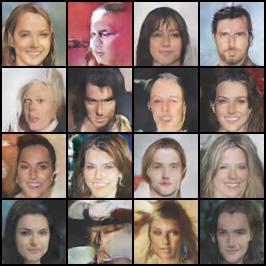

In [1]:
from IPython.display import Image
Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CelebA/DCGAN_epoch010.png", width = 256, height=256)

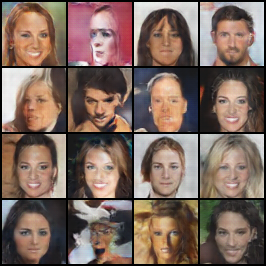

In [2]:
Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CelebA/DCGAN_epoch030.png", width = 256, height=256)

In [ ]:
Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CelebA/DCGAN_epoch006.png", width = 256, height=256)

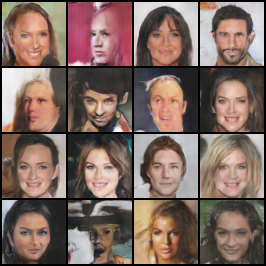

In [3]:
Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CelebA/DCGAN_epoch050.png", width = 256, height=256)

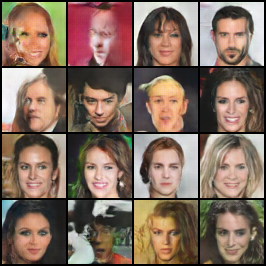

In [4]:
Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CelebA/DCGAN_epoch070.png", width = 256, height=256)

In [ ]:
# dcgan2 = DCGAN(opt)
# dcgan2.load_model()
# dcgan2.train()

In [ ]:
# Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CIFAR10/DCGAN_epoch006.png", width = 256, height=256)

In [ ]:
# Image("/home/jehyuk/GenerativeModels/GAN/results/DCGAN/CIFAR10/DCGAN_epoch010.png", width = 256, height=256)